# Initialization

In [1]:
#!pip show scikit-learn

In [2]:
import sys
import os
import random
import numpy as np
import cv2
import joblib

# Get Tensor Flow Set-up to handle the models

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing


#Set Parameters
batch = 32
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

# Connect to S3 Buckets 

In [3]:
%%time

#Imports for Bucket connections
import os
import boto3
import sagemaker
from sagemaker import get_execution_role

#Get the role to be able to connect to buckets
role = get_execution_role()

CPU times: user 190 ms, sys: 27.8 ms, total: 218 ms
Wall time: 273 ms


In [4]:
#Open a sample Bucket
#YOUR BUCKET HERE
model_bucket = 'medical-models-private'

models = []

#List contents of Bucket
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=model_bucket)['Contents']
for f in contents:
    models.append( f['Key'] )

#This should have the directories of all your models
models = models[0::]
print(models)

['Random_Forest/', 'Random_Forest/random_forest2.p', 'ResNet_model.h5', 'VGG16_model.h5', 'Xception_model.h5', 'random_forest.joblib', 'random_forest.p']


In [5]:
#pip install matplotlib

In [6]:
#pip install seaborn

# Loading the Pre-Trained Models

In [7]:
# Importing the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Loading the Data

In [8]:
#Open a sample Bucket
#YOUR BUCKET HERE
bucket = 'medical-images-test-images'

images = []

#List contents of Bucket
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket)['Contents']
for f in contents:
    images.append( f['Key'] )

#This should have the directories of all your images; printing the first ones in the list
print(images)

['glioma_tumor/image(18).jpg', 'glioma_tumor/image(19).jpg', 'glioma_tumor/image(2).jpg', 'meningioma_tumor/image(100).jpg', 'meningioma_tumor/image(102).jpg', 'meningioma_tumor/image(106).jpg', 'no_tumor/image(102).jpg', 'no_tumor/image(103).jpg', 'no_tumor/image(104).jpg', 'pituitary_tumor/image(27).jpg', 'pituitary_tumor/image(28).jpg', 'pituitary_tumor/image(3).jpg']


In [9]:
import cv2
import re
import pandas as pd

RESIZE_TO = 224

x, x_299, y = [], [], []

#Open client
s3client = boto3.client('s3')

#Load each image in, process and append to list
for file in images[::-1]:
    idx = file.find(r'/im')
    y.append(file[0:idx].lower())
    img = s3client.download_file(bucket, file, "/tmp/img.jpg")
    x.append(cv2.resize(cv2.imread("/tmp/img.jpg"), (RESIZE_TO, RESIZE_TO)))
    x_299.append(cv2.resize(cv2.imread("/tmp/img.jpg"), (299, 299)))

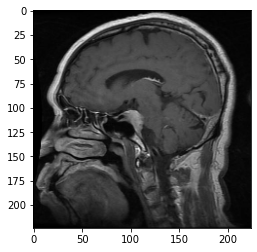

In [10]:
#Check to see that images loaded
from matplotlib.pyplot import imshow
imshow(x[0])
plt.show()

In [11]:
#copy all original images to the result bucket
#YOUR BUCKET HERE

result_bucket = 'medical-images-testing'
print(images)

for i in range(0,3):
    s3 = boto3.resource('s3')
    copy_source = {
        'Bucket': bucket,
        'Key': images[i]
    }
    s3.meta.client.copy(copy_source, result_bucket, 'Patient_1/image' + str(i) + "_org.jpg", ExtraArgs={'ACL':'public-read'})
    

for i in range(3,6):
    s3 = boto3.resource('s3')
    copy_source = {
        'Bucket': bucket,
        'Key': images[i]
    }
    s3.meta.client.copy(copy_source, result_bucket, 'Patient_2/image' + str(i) + "_org.jpg", ExtraArgs={'ACL':'public-read'})
    
for i in range(6,9):
    s3 = boto3.resource('s3')
    copy_source = {
        'Bucket': bucket,
        'Key': images[i]
    }
    s3.meta.client.copy(copy_source, result_bucket, 'Patient_3/image' + str(i) + "_org.jpg", ExtraArgs={'ACL':'public-read'})
    
for i in range(9,12):
    s3 = boto3.resource('s3')
    copy_source = {
        'Bucket': bucket,
        'Key': images[i]
    }
    s3.meta.client.copy(copy_source, result_bucket, 'Patient_4/image' + str(i) + "_org.jpg", ExtraArgs={'ACL':'public-read'})
        

['glioma_tumor/image(18).jpg', 'glioma_tumor/image(19).jpg', 'glioma_tumor/image(2).jpg', 'meningioma_tumor/image(100).jpg', 'meningioma_tumor/image(102).jpg', 'meningioma_tumor/image(106).jpg', 'no_tumor/image(102).jpg', 'no_tumor/image(103).jpg', 'no_tumor/image(104).jpg', 'pituitary_tumor/image(27).jpg', 'pituitary_tumor/image(28).jpg', 'pituitary_tumor/image(3).jpg']


In [12]:
y_orig = y
#y_test
from sklearn.preprocessing import LabelEncoder
y = np.array(y)
le = LabelEncoder()
le.fit(["pituitary_tumor", "no_tumor", "meningioma_tumor", "glioma_tumor"])
y = le.transform(y)

In [13]:
#Xception
x_cept = np.array(x_299)
x_cept = tf.keras.applications.xception.preprocess_input(x_cept, data_format = None)

#Resnet
x_res = np.array(x)
x_res = tf.keras.applications.resnet.preprocess_input(x_res, data_format = None)

### Loading Model: ResNet

In [14]:
#Loading Resnet Model

# Add the pretrained layers
pretrained_model = keras.applications.ResNet50(include_top=False, weights='imagenet', )

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.2)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model_1 = keras.Model(inputs=pretrained_model.input, outputs=output)


In [15]:
# If this doesn't work by default, try installing this version of h5py
#!pip install "h5py==2.10.0"

#Load the ResNet Weights

import pickle

my_bucket = model_bucket
my_file = 'ResNet_model.h5'
s3client = boto3.client('s3')
s3client.download_file(my_bucket, my_file, "/tmp/model1.h5")

#Load the saved weights
model_1.load_weights("/tmp/model1.h5")


In [16]:
#Inspect weights to ensure they loaded properly
import h5py
f = h5py.File('/tmp/model1.h5', 'r')
#list(f.keys())

In [17]:
# Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',    
              metrics=['sparse_categorical_accuracy'])

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["pituitary", "no_tumor", "meningioma", "glioma"]

y_pred_res = model_1.predict(x_res)
pred_res = np.argmax(y_pred_res, axis=1)

print(classification_report(y, pred_res, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y, pred_res) * 100)
print("\n")

[2021-11-26 18:18:08.338 ip-172-16-161-238:8915 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-26 18:18:08.375 ip-172-16-161-238:8915 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
              precision    recall  f1-score   support

   pituitary       0.00      0.00      0.00         3
    no_tumor       0.75      1.00      0.86         3
  meningioma       0.60      1.00      0.75         3
      glioma       1.00      1.00      1.00         3

    accuracy                           0.75        12
   macro avg       0.59      0.75      0.65        12
weighted avg       0.59      0.75      0.65        12

Accuracy :  75.0




/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Loading Model: Xception

In [19]:
# Loading Xception Model

# Add the pretrained layers
pretrained_model = keras.applications.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 30%
drop = keras.layers.Dropout(0.3)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model_2 = keras.Model(inputs=pretrained_model.input, outputs=output)


In [20]:
#Load the Xception Weights

my_file = 'Xception_model.h5'
s3client = boto3.client('s3')
result = s3client.download_file(my_bucket, my_file, "/tmp/model2.h5")

#Load the saved weights
model_2.load_weights("/tmp/model2.h5")


In [21]:
# Compile the model
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["pituitary", "no_tumor", "meningioma", "glioma"]

y_pred_xcept = model_2.predict(x_cept)
pred_xcept = np.argmax(y_pred_xcept, axis=1)
print(classification_report(y, pred_xcept, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y, pred_xcept) * 100)
print("\n")

              precision    recall  f1-score   support

   pituitary       0.00      0.00      0.00         3
    no_tumor       0.60      1.00      0.75         3
  meningioma       0.60      1.00      0.75         3
      glioma       1.00      0.67      0.80         3

    accuracy                           0.67        12
   macro avg       0.55      0.67      0.57        12
weighted avg       0.55      0.67      0.57        12

Accuracy :  66.66666666666666




/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Loading Model: VGG16

In [23]:
#Loading VGG16 Model

# Add the pretrained layers
pretrained_model = keras.applications.VGG16(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout
drop = keras.layers.Dropout(0.4)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)
model_3 = keras.Model(inputs=pretrained_model.input, outputs=output)


In [24]:
#Load the VGG16 Weights

my_file = 'VGG16_model.h5'
s3client = boto3.client('s3')
result = s3client.download_file(my_bucket, my_file, "/tmp/model3.h5")

#Load the saved weights
model_3.load_weights("/tmp/model3.h5")

In [25]:
# Compile the model
model_3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
#Classification report - VGG16
y_pred_VGG16 = model_3.predict(x_res)
pred_VGG16 = np.argmax(y_pred_VGG16, axis=1)
print(classification_report(y, pred_VGG16, target_names=class_names_tr))
print('VGG16 Results')
print("Accuracy : ", accuracy_score(y, pred_VGG16) * 100)
print("\n")

              precision    recall  f1-score   support

   pituitary       0.00      0.00      0.00         3
    no_tumor       0.60      1.00      0.75         3
  meningioma       0.60      1.00      0.75         3
      glioma       1.00      0.67      0.80         3

    accuracy                           0.67        12
   macro avg       0.55      0.67      0.57        12
weighted avg       0.55      0.67      0.57        12

VGG16 Results
Accuracy :  66.66666666666666




/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Merge Model Results

In [27]:
import pandas as pd
#Combining the models
df1 = pd.DataFrame(y_pred_res, columns = ["pituitary1", "no_tumor1", "meningioma1", "glioma1"])
df2 = pd.DataFrame(y_pred_xcept, columns = ["pituitary2", "no_tumor2", "meningioma2", "glioma2"])
df3 = pd.DataFrame(y_pred_VGG16, columns = ["pituitary3", "no_tumor3", "meningioma3", "glioma3"])
df_target = pd.DataFrame(y, columns = ['target'])

df1['pituitary2'] = df2['pituitary2']
df1['no_tumor2'] = df2['no_tumor2']
df1['meningioma2'] = df2['meningioma2']
df1['glioma2'] = df2['glioma2']

df1['pituitary3'] = df3['pituitary3']
df1['no_tumor3'] = df3['no_tumor3']
df1['meningioma3'] = df3['meningioma3']
df1['glioma3'] = df3['glioma3']

df1['target'] = df_target['target']

data = df1

# printing the dataset obseravtions
print("Dataset first few rows:\n ")
print(data.head(2))

print("\nSum of NULL values in each column. ")
print(data.isnull().sum())

Dataset first few rows:
 
     pituitary1     no_tumor1   meningioma1   glioma1    pituitary2  \
0  1.818808e-06  3.568707e-03  3.859706e-07  0.996429  1.207206e-01   
1  1.227543e-08  5.043671e-07  2.164785e-08  0.999999  1.311998e-09   

   no_tumor2   meningioma2   glioma2    pituitary3  no_tumor3  meningioma3  \
0   0.838721  2.481183e-02  0.015747  5.838748e-03   0.505915     0.050142   
1   0.000001  1.572019e-07  0.999999  2.329793e-10   0.000102     0.002329   

    glioma3  target  
0  0.438105       3  
1  0.997569       3  

Sum of NULL values in each column. 
pituitary1     0
no_tumor1      0
meningioma1    0
glioma1        0
pituitary2     0
no_tumor2      0
meningioma2    0
glioma2        0
pituitary3     0
no_tumor3      0
meningioma3    0
glioma3        0
target         0
dtype: int64


In [28]:
#split the dataset
# separate the predictor and target variable
X = data.values[:, 0:12]
Y = data.values[:, 12]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [29]:
#Load the Random Forest Model

my_file = 'random_forest.joblib'
s3client = boto3.client('s3')
result = s3client.download_file(my_bucket, my_file, "/tmp/model4.joblib")

#Load the saved weights
#model_3.load_weights("/tmp/model3.h5")
loaded_rf = joblib.load('/tmp/model4.joblib')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [30]:
# predicton on test using all features
X_test = data.values[:,0:12]
y_test = data.values[:,12]

y_pred = loaded_rf.predict(X_test)
y_pred_score = loaded_rf.predict_proba(X_test)

In [31]:
# calculate metrics gini model

print("\n")
print("Results Using All Features: \n")

print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("\n")

print("Accuracy : ", accuracy_score(y_test, y_pred) * 100)
print("\n")

#print("ROC_AUC : ", roc_auc_score(y_test,y_pred_score[:,1]) * 100)



Results Using All Features: 

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       1.00      1.00      1.00         3
         2.0       0.60      1.00      0.75         3
         3.0       1.00      1.00      1.00         3

    accuracy                           0.83        12
   macro avg       0.90      0.83      0.81        12
weighted avg       0.90      0.83      0.81        12



Accuracy :  83.33333333333334




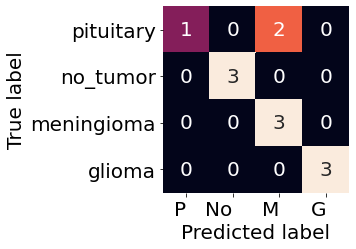

In [32]:
# confusion matrix for gini model
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ["pituitary", "no_tumor", "meningioma", "glioma"]
class_names2 = ["P", "No", "M", "G"]

df_cm = pd.DataFrame(conf_matrix, index=class_names2, columns=class_names )

plt.figure(figsize=(5,5))

hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20}, yticklabels=df_cm.columns, xticklabels=df_cm.index)

hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
# Show heat map
plt.tight_layout()
plt.savefig('confusion_matrix.jpg')

In [33]:
#Export to S3 bucket
import boto3

s3 = boto3.resource('s3')

#s3.Bucket(result_bucket).upload_file("confusion_matrix.jpg", "matrix")

In [34]:
#Make df of results

df_test = pd.DataFrame(y_pred_score, columns = ["pituitary", "no_tumor", "meningioma", "glioma"])
df_target = pd.DataFrame(y, columns = ['Actual'])
df_target2 = pd.DataFrame(y_pred, columns = ['Predicted'])
df_test['Predicted'] = df_target2['Predicted']
df_test['Actual'] = df_target['Actual']
df_test['Predicted'].replace({0: "pituitary", 1: "no_tumor", 2: "meningioma", 3:"glioma"}, inplace=True)
df_test["Actual"].replace({0: "pituitary", 1: "no_tumor", 2: "meningioma", 3:"glioma"}, inplace=True)
print(df_test)

    pituitary  no_tumor  meningioma  glioma   Predicted      Actual
0        0.22      0.01        0.04    0.73      glioma      glioma
1        0.00      0.00        0.00    1.00      glioma      glioma
2        0.00      0.00        0.00    1.00      glioma      glioma
3        0.04      0.01        0.95    0.00  meningioma  meningioma
4        0.03      0.00        0.97    0.00  meningioma  meningioma
5        0.10      0.01        0.89    0.00  meningioma  meningioma
6        0.00      1.00        0.00    0.00    no_tumor    no_tumor
7        0.44      0.55        0.01    0.00    no_tumor    no_tumor
8        0.31      0.68        0.00    0.01    no_tumor    no_tumor
9        0.62      0.28        0.02    0.08   pituitary   pituitary
10       0.06      0.00        0.94    0.00  meningioma   pituitary
11       0.05      0.03        0.92    0.00  meningioma   pituitary


In [35]:
#pip install dataframe_image

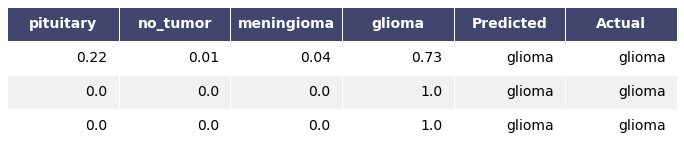

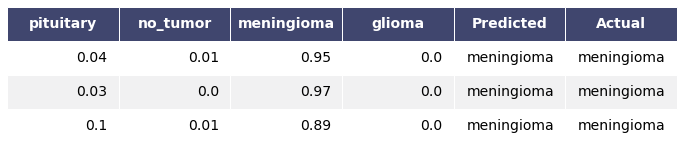

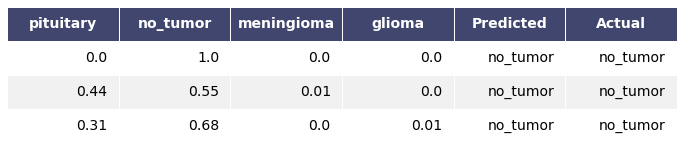

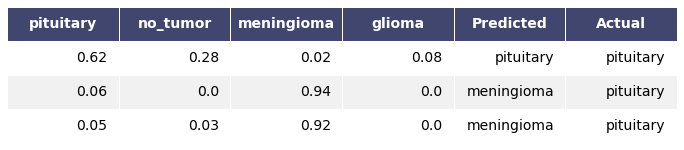

In [36]:
#Create Table from Dataframe

df = df_test
df1 = df.iloc[0:3]
df2 = df.iloc[3:6]
df3 = df.iloc[6:9]
df4 = df.iloc[9:12]

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df1, header_columns=0, col_width=2.0)
fig.savefig("table1_mpl.png")
fig,ax = render_mpl_table(df2, header_columns=0, col_width=2.0)
fig.savefig("table2_mpl.png")
fig,ax = render_mpl_table(df3, header_columns=0, col_width=2.0)
fig.savefig("table3_mpl.png")
fig,ax = render_mpl_table(df4, header_columns=0, col_width=2.0)
fig.savefig("table4_mpl.png")

In [37]:
#Export table to S3 bucket
import boto3

s3 = boto3.resource('s3')
s3.Bucket(result_bucket).upload_file("table1_mpl.png", "Patient_1/table.jpg", ExtraArgs={'ACL':'public-read'})
s3.Bucket(result_bucket).upload_file("table2_mpl.png", "Patient_2/table.jpg", ExtraArgs={'ACL':'public-read'})
s3.Bucket(result_bucket).upload_file("table3_mpl.png", "Patient_3/table.jpg", ExtraArgs={'ACL':'public-read'})
s3.Bucket(result_bucket).upload_file("table4_mpl.png", "Patient_4/table.jpg", ExtraArgs={'ACL':'public-read'})

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ExtraArgs" which is no longer supported as of 3.3 and will become an error two minor releases later


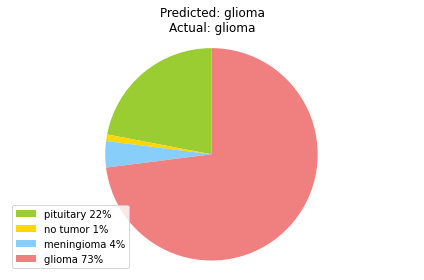

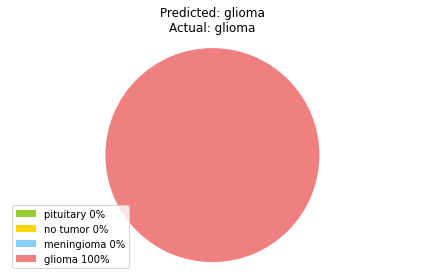

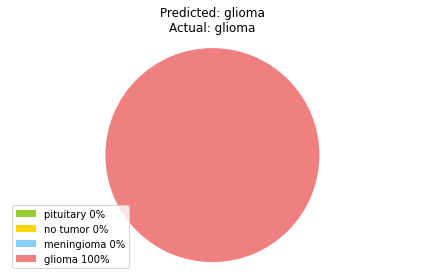

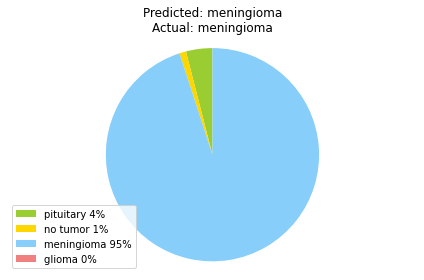

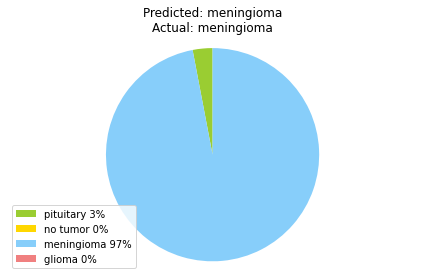

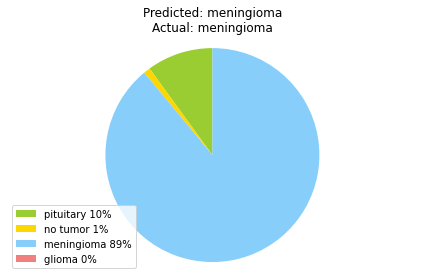

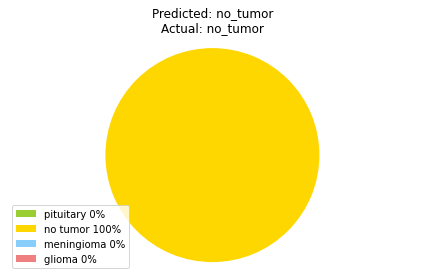

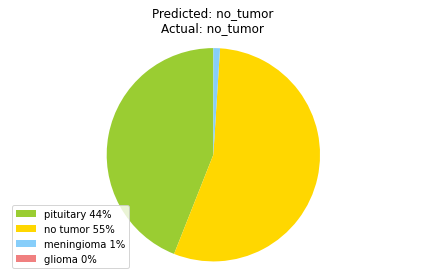

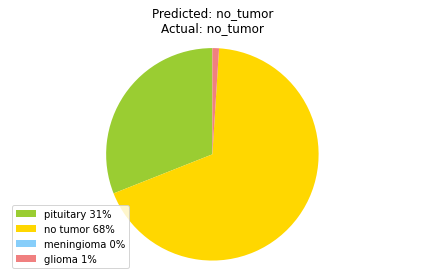

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


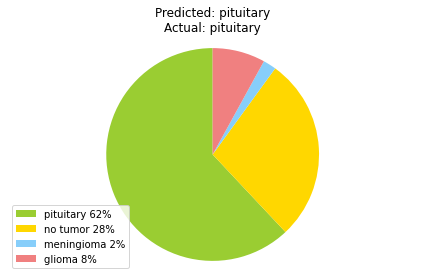

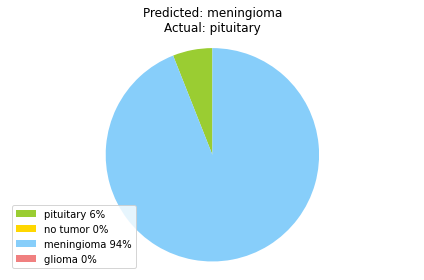

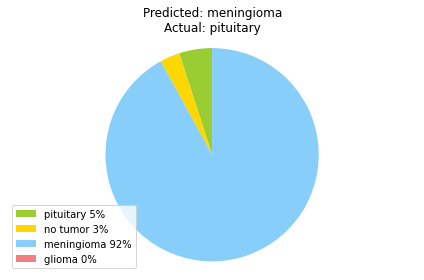

In [38]:
#Create and save pie charts to results bucket
import matplotlib.pyplot as plt

for i in range(len(images)):
    data = df.iloc[i, 0:4]
    labels = [r'pituitary ' + str(round(df.iloc[i,0]*100)) + '%', r'no tumor ' + str(round(df.iloc[i,1]*100)) + '%', 
r'meningioma ' + str(round(df.iloc[i,2]*100)) + '%' , r'glioma ' + str(round(df.iloc[i,3]*100)) + '%']
    sizes = data
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="lower left")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title('Predicted: ' + df.iloc[i,4] + "\n" + 'Actual: ' + df.iloc[i,5])
    plt.tight_layout()
    
    plt.savefig('image' + str(i) + '_pie.jpg', ExtraArgs={'ACL':'public-read'})
    plt.show()
    #s3.Bucket(result_bucket).upload_file('image' + str(i) + '_pie.png', 'image' + str(i) + '_pie.png')

In [39]:
for i in range(0,3):
    s3.Bucket(result_bucket).upload_file('image' + str(i) + '_pie.jpg', 'Patient_1/image' + str(i) + '_pie.jpg', ExtraArgs={'ACL':'public-read'})
    
for i in range(3,6):
    s3.Bucket(result_bucket).upload_file('image' + str(i) + '_pie.jpg', 'Patient_2/image' + str(i) + '_pie.jpg', ExtraArgs={'ACL':'public-read'})  

for i in range(6,9):
    s3.Bucket(result_bucket).upload_file('image' + str(i) + '_pie.jpg', 'Patient_3/image' + str(i) + '_pie.jpg', ExtraArgs={'ACL':'public-read'}) 
    
for i in range(9,12):
    s3.Bucket(result_bucket).upload_file('image' + str(i) + '_pie.jpg', 'Patient_4/image' + str(i) + '_pie.jpg', ExtraArgs={'ACL':'public-read'})  